✅ Dataset Loaded Successfully
        Date            Timestamp  Region  Soil Moisture (%)  Rainfall (mm)  \
0 2020-01-01  2020-01-01 00:00:00  Odisha           0.603667            0.0   
1 2020-01-02  2020-01-02 00:00:00  Odisha           0.597333            4.0   
2 2020-01-03  2020-01-03 00:00:00  Odisha           0.595000            0.0   
3 2020-01-04  2020-01-04 00:00:00  Odisha           0.591000            1.0   
4 2020-01-05  2020-01-05 00:00:00  Odisha           0.584000            1.3   

   Water Level (cm)  Temperature (°C)  Humidity (%)  Pressure (hPa)  Latitude  \
0              12.6              24.2          50.6          1016.0   20.9517   
1              12.5              22.6          57.9          1018.0   20.9517   
2               8.0              21.8          52.3          1015.6   20.9517   
3               5.0              21.0          56.2          1017.4   20.9517   
4               5.0              21.7          61.5          1012.3   20.9517   

   Longi

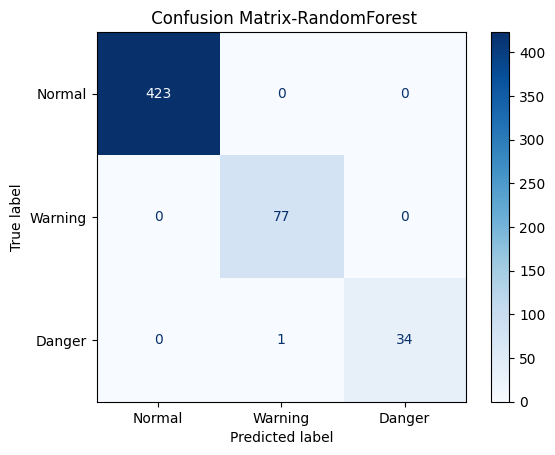

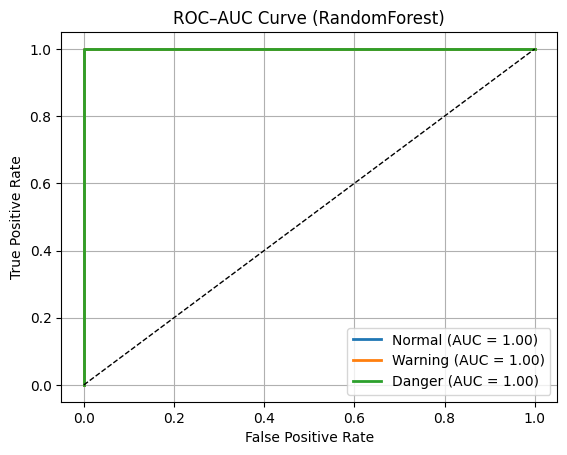

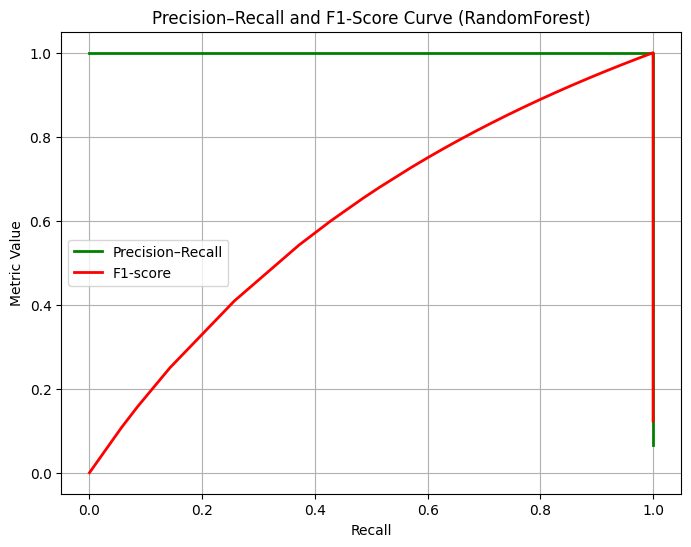

🌧️ Flood Risk Prediction:
Normal:  9.00%
Danger:  79.50%

Predicted Status: 🚨 Danger
⚙️ Adaptive Thresholds Updated:
Recent Average Rainfall: 1.63 mm/hr
Warning Threshold: 49.76
Danger Threshold: 79.84
🚨 DANGER — Start pump, raise barrier, and send emergency alert!


In [ ]:
#pip install numpy pandas scikit-learn matplotlib xgboost
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

### 2. Load Your Excel Dataset
import pandas as pd
df = pd.read_excel("C:\\Users\\Lenovo\\Desktop\\jupyter ML PPROJECTS\\Flood_prediction_combined_data_set(1).csv")
print(" Dataset Loaded Successfully")
print(df.head())

 ### Step 3: Preprocess Data and Rename Columns
# Rename columns for consistent naming
df = df.rename(columns={
    "Soil Moisture (%)": "SoilMoisture",
    "Rainfall (mm)": "Rainfall_mm",
    "Water Level (cm)": "WaterLevel_cm",
    "Temperature (°C)": "Temperature_C",
    "Humidity (%)": "Humidity_pct",
    "Pressure (hPa)": "Pressure_hPa"
})
# Keep only the useful columns for AI processing
df = df[['Date','Region','Rainfall_mm','WaterLevel_cm','SoilMoisture',
         'Temperature_C','Humidity_pct','Pressure_hPa']]
# Convert date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

print("Columns Cleaned and Standardized")
print(df.head())

# Step 4 — Create Flood Risk Labels using data-driven thresholds
# Compute thresholds dynamically from data
p75_rain = df['Rainfall_mm'].quantile(0.75)
p90_rain = df['Rainfall_mm'].quantile(0.90)
p75_wl   = df['WaterLevel_cm'].quantile(0.75)
p90_wl   = df['WaterLevel_cm'].quantile(0.90)
# Define risk conditions
conditions = [
    (df['Rainfall_mm'] > p90_rain) & (df['WaterLevel_cm'] > p90_wl),
    (df['Rainfall_mm'] > p75_rain) & (df['WaterLevel_cm'] > p75_wl),
    (df['Rainfall_mm'] <= p75_rain) & (df['WaterLevel_cm'] <= p75_wl)
]
labels = ['Danger', 'Warning', 'Normal']
# Apply labels
df['FloodLabelText'] = np.select(conditions, labels, default='Normal')
df['FloodLabel'] = df['FloodLabelText'].map({'Normal': 0, 'Warning': 1, 'Danger': 2})
print("Flood Label Distribution:")
print(df['FloodLabelText'].value_counts())
df.head(10)

### Step 5: Prepare Data for the AI Model
# Select input features and target label
X = df[['Rainfall_mm','WaterLevel_cm','SoilMoisture','Temperature_C','Humidity_pct','Pressure_hPa']]
y = df['FloodLabel']
# Normalize input features for model stability
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Split dataset into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)
print("Data prepared successfully!")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

### Step 6: Train the Random Forest Model
# Initialize and train Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Show results
print(" Model Trained Successfully!")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred))

### Step 7: Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Warning', 'Danger'])
disp.plot(cmap='Blues')
plt.title(" Confusion Matrix-RandomForest")
plt.show()
# ========== Step 7B — ROC–AUC Curve (Multiclass) ==========
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Binarize classes for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
# Predict probabilities
y_score = model.predict_proba(X_test)
# Compute ROC curve & AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC Curve
plt.figure()
for i, label in zip([0,1,2], ['Normal', 'Warning', 'Danger']):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve (RandomForest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
# ========== Step 7C — Precision-Recall and F1 Curve (Danger Class) ==========
from sklearn.metrics import precision_recall_curve, f1_score
# True binary labels (Danger = 1)
y_true_bin = (y_test == 2).astype(int)
# Predicted probabilities for Danger class
danger_prob = y_score[:, 2]
# Precision–Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_true_bin, danger_prob)
# Compute F1 at each point along recall (matching threshold of PR curve)
f1_scores = []
for p, r in zip(precision, recall):
    if p + r == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(2 * (p * r) / (p + r))  # harmonic mean
# ===== Plot =====
plt.figure(figsize=(8, 6))
# Precision–Recall curve (green)
plt.plot(recall, precision, color='green', linewidth=2, label='Precision–Recall')
# F1 curve (red)
plt.plot(recall, f1_scores, color='red', linewidth=2, label='F1-score')
plt.xlabel("Recall")
plt.ylabel("Metric Value")
plt.title("Precision–Recall and F1-Score Curve (RandomForest)")
plt.grid(True)
plt.legend()
plt.show()

### Step 8 – Real-Time Prediction
# Example current readings (replace these with live sensor values later)
# Format → [Rainfall_mm, WaterLevel_cm, SoilMoisture, Temperature_C, Humidity_pct, Pressure_hPa]
sample = [[60, 110, 0.75, 29, 85, 995]]  # moderate rainfall, high humidity
prob = model.predict_proba(sample)[0]
pred = model.predict(sample)[0]
labels = {0:' Normal', 1:' Warning', 2:' Danger'}
print(" Flood Risk Prediction:")
print(f"Normal:  {prob[0]*100:.2f}%")
print(f"Warning: {prob[1]*100:.2f}%")
print(f"Danger:  {prob[2]*100:.2f}%")
print("\nPredicted Status:", labels[pred])

### Step 9: Adaptive Threshold Logic
recent_avg_rain = df['Rainfall_mm'].tail(10).mean()
# Adjust thresholds dynamically
warning_threshold = 50 - (recent_avg_rain * 0.15)
danger_threshold  = 80 - (recent_avg_rain * 0.10)
print(" Adaptive Thresholds Updated:")
print("Recent Average Rainfall:", round(recent_avg_rain, 2), "mm/hr")
print("Warning Threshold:", round(warning_threshold, 2))
print("Danger Threshold:", round(danger_threshold, 2))

### Step 10 – Decision Logic and Action Layer
def flood_action(predicted_label):
    if predicted_label == 0:
        print(" NORMAL — All safe. No action needed.")
    elif predicted_label == 1:
        print(" WARNING — Activate buzzer and send cloud alert.")
    else:
        print(" DANGER — Start pump, raise barrier, and send emergency alert!")
# Test the decision logic using your last prediction
flood_action(pred)




✅ Dataset Loaded Successfully
        Date            Timestamp  Region  Soil Moisture (%)  Rainfall (mm)  \
0 2020-01-01  2020-01-01 00:00:00  Odisha           0.603667            0.0   
1 2020-01-02  2020-01-02 00:00:00  Odisha           0.597333            4.0   
2 2020-01-03  2020-01-03 00:00:00  Odisha           0.595000            0.0   
3 2020-01-04  2020-01-04 00:00:00  Odisha           0.591000            1.0   
4 2020-01-05  2020-01-05 00:00:00  Odisha           0.584000            1.3   

   Water Level (cm)  Temperature (°C)  Humidity (%)  Pressure (hPa)  Latitude  \
0              12.6              24.2          50.6          1016.0   20.9517   
1              12.5              22.6          57.9          1018.0   20.9517   
2               8.0              21.8          52.3          1015.6   20.9517   
3               5.0              21.0          56.2          1017.4   20.9517   
4               5.0              21.7          61.5          1012.3   20.9517   

   Longi

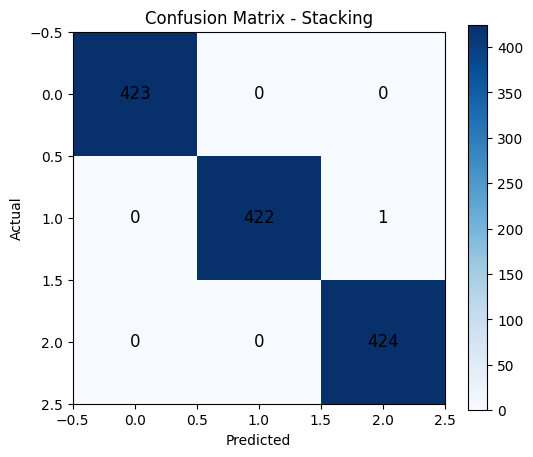

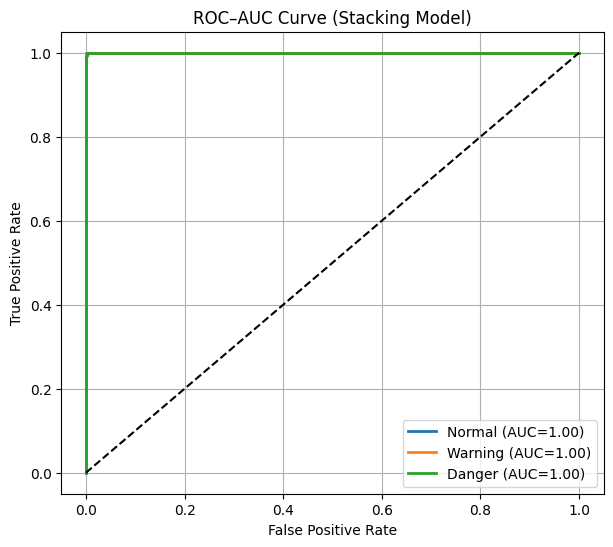

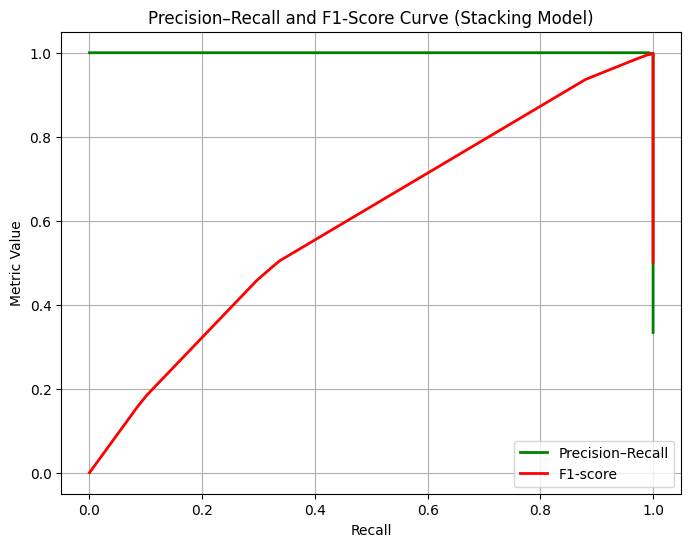

Per-class ROC-AUC: [np.float64(1.0), np.float64(0.9999916266840831), np.float64(0.9999916365582765)]
✅ Models and scaler saved: Stacking_FloodModel.pkl, Scaler.pkl
 Flood Risk Prediction:
Normal:  0.01%
Danger:  99.99%

Predicted Status: 🚨 Danger
 Adaptive Thresholds Updated:
Recent Average Rainfall: 1.63 mm/hr
Warning Threshold: 49.76
Danger Threshold: 79.84
DANGER — Start pump, raise barrier, and send emergency alert!


In [1]:
#pip install numpy pandas scikit-learn matplotlib xgboost
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
# Disable all warnings
import warnings
warnings.filterwarnings("ignore")

### 2. Load Your Excel Dataset
import pandas as pd
df = pd.read_excel("C:\\Users\\Lenovo\\Desktop\\jupyter ML PPROJECTS\\Flood_prediction_combined_data_set(1).csv")
print("✅ Dataset Loaded Successfully")
print(df.head())
 
 ### Step 3: Preprocess Data and Rename Columns
# Rename columns for consistent naming
df = df.rename(columns={
    "Soil Moisture (%)": "SoilMoisture",
    "Rainfall (mm)": "Rainfall_mm",
    "Water Level (cm)": "WaterLevel_cm",
    "Temperature (°C)": "Temperature_C",
    "Humidity (%)": "Humidity_pct",
    "Pressure (hPa)": "Pressure_hPa"
})
# Keep only the useful columns for AI processing
df = df[['Date','Region','Rainfall_mm','WaterLevel_cm','SoilMoisture',
         'Temperature_C','Humidity_pct','Pressure_hPa']]
# Convert date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])
print("✅ Columns Cleaned and Standardized")
print(df.head())

# Step 4 — Create Flood Risk Labels using data-driven thresholds
# Compute thresholds dynamically from data
p75_rain = df['Rainfall_mm'].quantile(0.75)
p90_rain = df['Rainfall_mm'].quantile(0.90)
p75_wl   = df['WaterLevel_cm'].quantile(0.75)
p90_wl   = df['WaterLevel_cm'].quantile(0.90)
# Define risk conditions
conditions = [
    (df['Rainfall_mm'] > p90_rain) & (df['WaterLevel_cm'] > p90_wl),
    (df['Rainfall_mm'] > p75_rain) & (df['WaterLevel_cm'] > p75_wl),
    (df['Rainfall_mm'] <= p75_rain) & (df['WaterLevel_cm'] <= p75_wl)
]
labels = ['Danger', 'Warning', 'Normal']
# Apply labels
df['FloodLabelText'] = np.select(conditions, labels, default='Normal')
df['FloodLabel'] = df['FloodLabelText'].map({'Normal': 0, 'Warning': 1, 'Danger': 2})
print("📊 Flood Label Distribution:")
print(df['FloodLabelText'].value_counts())
df.head(10)

### Step 5: Prepare Data for the AI Model
# Select input features and target label
X = df[['Rainfall_mm','WaterLevel_cm','SoilMoisture','Temperature_C','Humidity_pct','Pressure_hPa']]
y = df['FloodLabel']
# Normalize input features for model stability
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Split dataset into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)
print("✅ Data prepared successfully!")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# --- START Stacking training & evaluation (replace Step 6-7) ---
# Install extra packages if needed (run once in a cell)
# !pip install imbalanced-learn xgboost
# Imports
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
# 1) OPTIONAL: SMOTE to handle imbalance (recommended by paper)
DO_SMOTE = True
if DO_SMOTE:
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_scaled, y)
    print("After SMOTE, class counts:", np.bincount(y_res))
else:
    X_res, y_res = X_scaled, y
# 2) OPTIONAL: RF-RFE feature selection (paper uses RF-RFE)
DO_RFE = False   # set True to enable RFE
rfe_features_idx = None
if DO_RFE:
    rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    # choose number of features to keep, e.g., half of features
    n_features_to_select = max(2, X_res.shape[1] // 2)
    rfe = RFE(rf_for_rfe, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X_res, y_res)
    rfe_features_idx = rfe.get_support(indices=True)
    print("RFE selected feature indices:", rfe_features_idx)
    X_res = X_res[:, rfe_features_idx]
# 3) Prepare base learners (weak learners)
base_estimators = [
    ('dt', DecisionTreeClassifier(max_depth=6, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1)),
    ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
    # MultinomialNB expects non-negative features (if you have negatives after scaling, skip or use GaussianNB)
    ('mnb', MultinomialNB()),  
    ('mlp', MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42))
]
# NOTE: if MultinomialNB fails due to negative values after scaling, set DO_RFE True and/or use GaussianNB:
# from sklearn.naive_bayes import GaussianNB
# replace ('mnb', MultinomialNB()) with ('gnb', GaussianNB())
# 4) Meta-learner = XGBoost
from xgboost import XGBClassifier
meta_clf = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
# 5) Build stacking classifier (cv for internal OOF stacking)
stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_clf,
    cv=5,              # important: cross-validated stacking to avoid leakage
    n_jobs=-1,
    passthrough=False  # set True if you want original features appended to meta-input
)
# 6) Train/test split on resampled dataset (or use your X_train/X_test from earlier)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_res, y_res, test_size=0.25, random_state=42, stratify=y_res)
print("Training on", X_tr.shape[0], "samples; testing on", X_te.shape[0], "samples")
# Fit stacking model
stack_clf.fit(X_tr, y_tr)
print("✅ Stacking model trained.")


# 7) Evaluate
y_pred = stack_clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
print(f"Accuracy (stacking): {acc*100:.2f}%")
print(classification_report(y_te, y_pred, digits=4))

# --- Confusion Matrix with numbers ---
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Stacking")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='black', fontsize=12)

plt.colorbar()
plt.show()
# ========== Step 7B — ROC–AUC Curve (Multiclass) for Stacking Model ==========
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Number of classes
n_classes = len(np.unique(y))
# Binarize true labels
y_test_bin = label_binarize(y_te, classes=list(range(n_classes)))
# Predict probabilities
y_score = stack_clf.predict_proba(X_te)
# Compute ROC curve & AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# ----- Plot -----
plt.figure(figsize=(7,6))
for i, label in zip([0,1,2], ['Normal', 'Warning', 'Danger']):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label} (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve (Stacking Model)')
plt.legend()
plt.grid(True)
plt.show()
# ========== Step 7C — Precision-Recall & F1 Curve (Danger Class) ==========
from sklearn.metrics import precision_recall_curve
# Convert to binary (Danger = 1)
y_true_bin = (y_te == 2).astype(int)
# Predicted probabilities of Danger class
danger_prob = y_score[:, 2]
# Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_true_bin, danger_prob)
# F1 computed at each (precision, recall)
f1_scores = []
for p, r in zip(precision, recall):
    if p + r == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(2 * (p * r) / (p + r))
# ---- Plot -----
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', linewidth=2, label="Precision–Recall")
plt.plot(recall, f1_scores, color='red', linewidth=2, label="F1-score")
plt.xlabel("Recall")
plt.ylabel("Metric Value")
plt.title("Precision–Recall and F1-Score Curve (Stacking Model)")
plt.legend()
plt.grid(True)
plt.show()
# Optional: multiclass ROC-AUC (binarize labels)
try:
    n_classes = len(np.unique(y))
    y_test_bin = label_binarize(y_te, classes=list(range(n_classes)))
    y_score = stack_clf.predict_proba(X_te)
    aucs = []
    for i in range(n_classes):
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc)
    print("Per-class ROC-AUC:", aucs)
except Exception as e:
    print("ROC-AUC skipped (reason):", e)
# 8) Save trained stacking model and optionally scaler and RFE indices
joblib.dump(stack_clf, "Stacking_FloodModel.pkl")
joblib.dump(scaler, "Scaler.pkl")
if rfe_features_idx is not None:
    joblib.dump(rfe_features_idx, "RFE_features_idx.pkl")
print("✅ Models and scaler saved: Stacking_FloodModel.pkl, Scaler.pkl")
# --- END Stacking training & evaluation ---

### Step 8 – Real-Time Prediction
import joblib
import numpy as np
# Load model and scaler
model = joblib.load("Stacking_FloodModel.pkl")
scaler = joblib.load("Scaler.pkl")
# Example sensor values
sample = np.array([[60, 110, 0.75, 29, 85, 995]])
# 1) SCALE the input
sample_scaled = scaler.transform(sample)
# 2) Predict
prob = model.predict_proba(sample_scaled)[0]
pred = model.predict(sample_scaled)[0]
labels = {0:'✅ Normal', 1:'⚠️ Warning', 2:'🚨 Danger'}
print(" Flood Risk Prediction:")
print(f"Normal:  {prob[0]*100:.2f}%")
print(f"Warning: {prob[1]*100:.2f}%")
print(f"Danger:  {prob[2]*100:.2f}%")
print("\nPredicted Status:", labels[pred])

# Step 9: Adaptive Threshold Logic
recent_avg_rain = df['Rainfall_mm'].tail(10).mean()
# Adjust thresholds dynamically
warning_threshold = 50 - (recent_avg_rain * 0.15)
danger_threshold  = 80 - (recent_avg_rain * 0.10)
print(" Adaptive Thresholds Updated:")
print("Recent Average Rainfall:", round(recent_avg_rain, 2), "mm/hr")
print("Warning Threshold:", round(warning_threshold, 2))
print("Danger Threshold:", round(danger_threshold, 2))

# Step 10: Decision Logic and Action Layer
def flood_action(predicted_label):
    if predicted_label == 0:
        print(" NORMAL — All safe. No action needed.")
    elif predicted_label == 1:
        print(" WARNING — Activate buzzer and send cloud alert.")
    else:
        print("DANGER — Start pump, raise barrier, and send emergency alert!")
# Test the decision logic using your last prediction
flood_action(pred)



In [1]:
# ============================================================
# 🔵 STEP 4 — DECISION LOGIC & RESPONSE (FULL CODE)
# Cells 1 to 7 combined into one copy-paste block
# ============================================================


# ============================================================
# 📌 CELL 1 — Install + Import Libraries
# ============================================================

!pip install pyserial requests

import time
import json
import joblib
import numpy as np
import requests
import serial
from pathlib import Path

print("✅ Step-4 Libraries Loaded")



# ============================================================
# 📌 CELL 2 — Decision Logic Function
# ============================================================

def decide_action_from_probs(probs):
    """
    probs = [p_normal, p_warning, p_danger]
    returns dictionary with actions + label
    """
    p_normal, p_warning, p_danger = probs
    risk_pct = p_danger * 100          # using danger probability
    label_index = int(np.argmax(probs))

    label_map = {0: "NORMAL", 1: "WARNING", 2: "DANGER"}

    # Step-4 Threshold Mapping
    if risk_pct < 30:
        action = "DATA_LOG"
    elif 30 <= risk_pct <= 70:
        action = "WARN"
    else:
        action = "DANGER"

    return {
        "risk_pct": round(risk_pct, 2),
        "label_index": label_index,
        "label_text": label_map[label_index],
        "action": action
    }



# ============================================================
# 📌 CELL 3 — Basic Console Simulation for Checking Logic
# ============================================================

probs_example = [0.09, 0.115, 0.795]
decision = decide_action_from_probs(probs_example)

print("Flood Risk Probability:", decision['risk_pct'], "%")
print("Risk Label:", decision['label_text'])
print("Action:", decision['action'])

if decision['action'] == "DATA_LOG":
    print("→ NORMAL: log database entry only")
elif decision['action'] == "WARN":
    print("→ WARNING: buzzer short beep + send cloud alert")
else:
    print("→ DANGER: buzzer continuous, pump ON, barrier OPEN, send SMS")



# ============================================================
# 📌 CELL 4 — Serial Communication Functions
# ============================================================

def open_serial(port, baud=9600, timeout=1, retries=3):
    for attempt in range(retries):
        try:
            ser = serial.Serial(port, baud, timeout=timeout)
            time.sleep(1)
            return ser
        except Exception as e:
            print(f"Attempt {attempt+1} failed:", e)
            time.sleep(1)
    print("❌ Unable to open serial port")
    return None


def send_risk_over_serial(ser, label_index):
    if ser is None:
        print("❌ No serial connection")
        return False
    try:
        ser.write(str(label_index).encode())     # Sends '0', '1', or '2'
        time.sleep(0.2)
        return True
    except Exception as e:
        print("❌ Serial Send Error:", e)
        return False



# ============================================================
# 📌 CELL 5 — CLOUD ALERT (IFTTT Webhook)
# ============================================================

IFTTT_EVENT_NAME = "flood_alert"
IFTTT_KEY = "YOUR_IFTTT_KEY"     # <-- replace with actual key

def send_ifttt_alert(label_text, risk_pct, location="Odisha"):
    if IFTTT_KEY == "YOUR_IFTTT_KEY":
        print("⚠️ IFTTT key missing — skipping alert")
        return False

    url = f"https://maker.ifttt.com/trigger/{IFTTT_EVENT_NAME}/with/key/{IFTTT_KEY}"
    payload = {"value1": label_text, "value2": str(risk_pct), "value3": location}

    try:
        r = requests.post(url, json=payload, timeout=5)
        print("IFTTT Response:", r.status_code)
        return True
    except Exception as e:
        print("❌ IFTTT Error:", e)
        return False



# ============================================================
# 📌 CELL 6 — FULL ONE-SHOT PIPELINE (AI → Decision → Hardware)
# ============================================================

COM_PORT = "COM3"
SEND_TO_SERIAL = False
SEND_CLOUD_ALERT = False

# Load model & scaler
try:
    model = joblib.load("Stacking_FloodModel.pkl")
    scaler = joblib.load("Scaler.pkl")
    print("✅ Model & Scaler Loaded")
except:
    print("⚠️ Model/Scaler Missing — using demo values")
    model = None
    scaler = None

# Example sensor reading
sensor_reading = [60, 110, 0.75, 29, 85, 995]

# Predict
if model and scaler:
    scaled = scaler.transform([sensor_reading])
    probs = model.predict_proba(scaled)[0]
else:
    probs = [0.09, 0.115, 0.795]     # demo

decision = decide_action_from_probs(probs)
print("Decision:", decision)

# SERIAL
if SEND_TO_SERIAL:
    ser = open_serial(COM_PORT)
    send_risk_over_serial(ser, decision['label_index'])
    if ser: ser.close()

# CLOUD ALERT
if SEND_CLOUD_ALERT and decision["action"] in ("WARN", "DANGER"):
    send_ifttt_alert(decision['label_text'], decision['risk_pct'])

# LOCAL ACTION MESSAGE
if decision['action'] == "DATA_LOG":
    print("→ NORMAL: log only")
elif decision['action'] == "WARN":
    print("→ WARNING: buzzer short + cloud alert")
else:
    print("→ DANGER: pump ON + barrier OPEN + buzzer continuous + SMS")



# ============================================================
# 📌 CELL 7 — LIMITED TEST LOOP (Runs 3 Times)
# ============================================================
# ============================================================
# 📌 CELL 7 — FAST TEST LOOP (No waiting delays)
# ============================================================

COM_PORT = "COM3"
SEND_CLOUD_ALERT = False

results = []

# Skip serial for speed
ser = None  

print("\n🔁 Running FAST 1-cycle test...\n")

for i in range(1):      # only 1 loop for speed
    probs = [0.10, 0.20, 0.70]   
    decision = decide_action_from_probs(probs)
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S")

    print(f"{timestamp} | Test {i+1} →", decision)

    if SEND_CLOUD_ALERT and decision['action'] != "DATA_LOG":
        send_ifttt_alert(decision['label_text'], decision['risk_pct'])

    results.append((timestamp, decision))

print("\n✅ FAST Test Completed")
print("Summary:")
for t, d in results:
    print("→", t, d)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Step-4 Libraries Loaded
Flood Risk Probability: 79.5 %
Risk Label: DANGER
Action: DANGER
→ DANGER: buzzer continuous, pump ON, barrier OPEN, send SMS
✅ Model & Scaler Loaded
Decision: {'risk_pct': np.float32(99.99), 'label_index': 2, 'label_text': 'DANGER', 'action': 'DANGER'}
→ DANGER: pump ON + barrier OPEN + buzzer continuous + SMS

🔁 Running FAST 1-cycle test...

2025-12-06 22:45:45 | Test 1 → {'risk_pct': 70.0, 'label_index': 2, 'label_text': 'DANGER', 'action': 'WARN'}

✅ FAST Test Completed
Summary:
→ 2025-12-06 22:45:45 {'risk_pct': 70.0, 'label_index': 2, 'label_text': 'DANGER', 'action': 'WARN'}


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
